# III. Modeling

For this part, we will buid a model to predict the nan value in `Price` collumns.


## 1.  Import necesary libraries

In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

## 2. Load data set

In [2]:
df = pd.read_csv('data/proccessed_data.csv', index_col = 0)

In [3]:
df.head()

,Date Posted,Address,Area,Price,Number of Bedrooms,Number of Toilets,Category,City,Price Level,Number of Rooms,Furniture,District,Price Range
0,15/10/2024,"Sunrise City, 23,25,27,33, Đường Nguyễn Hữu Th...",80.0,NaN,2.0,2.0,Căn hộ chung cư,Thành phố Hồ Chí Minh,-1,2.0,Unspecified,Quận 7,Thỏa thuận
1,15/10/2024,"131-133, Đường Đặng Tiến Đông, Phường Trung Li...",220.0,50000000.0,NaN,18.0,Văn phòng,Hà Nội,6,1.0,Basic,Đống đa,40 - 70 triệu
2,10/10/2024,"Dự án Opal Skyline, Đường Nguyễn Văn Tiết, Phư...",65.0,4000000.0,2.0,2.0,Căn hộ chung cư,Bình Dương,3,2.0,Fully Furnished,Thuận an,3 - 5 triệu
3,15/10/2024,"Dự án Opal Skyline, Đường Nguyễn Văn Tiết, Phư...",66.0,4000000.0,2.0,2.0,Căn hộ chung cư,Bình Dương,3,2.0,Fully Furnished,Thuận an,3 - 5 triệu
4,06/10/2024,"Dự án Vinhomes Ocean Park Gia Lâm, Đường Ngọc ...",55.0,5000000.0,2.0,1.0,Căn hộ chung cư,Hà Nội,4,2.0,Unfurnished,Gia lâm,5 - 10 triệu


## 3. Preprocessing data

We should reduce the data price for smallerr number

In [4]:
df['Price'] = df['Price'] / 1000000

In [5]:
df_train = df.copy()

### 3.1 Remove Unnecessary Columns

Now we don't need the `Address` collumn anymore.

In [6]:
df_train.drop(columns=['Address'], inplace=True)
df_train.drop(columns=['Price Range'], inplace=True)
df_train.drop(columns=['Price Level'], inplace=True)
df_train.drop(columns=['Date Posted'], inplace=True)


### 3.2: Check for Missing Values

In [7]:
missing_values = df_train.isnull().sum()/len(df)*100
missing_values

,0
Area,0.000000
Price,6.429549
Number of Bedrooms,34.062927
Number of Toilets,30.369357
Category,0.000000
City,0.000000
Number of Rooms,0.000000
Furniture,0.000000
District,0.000000


### 3.3 Handle Missing Values

To handle missing values in the 'Number of Bedrooms' and 'Number of Toilets' columns using your approach, we'll use the following steps:
- Find the rows with the closest 'Area' that have the same 'Category' and non-missing values.
- Use these similar rows to fill the missing values.
- If no similar rows are found, we use the median of the column to fill the missing value

In [8]:
def fill_missing_values(df, target_column, area_column='Area', category_column='Category'):
    for idx, row in df[df[target_column].isnull()].iterrows():
        similar_rows = df[(df[category_column] == row[category_column]) & (df[target_column].notna())]

        if not similar_rows.empty:
            closest_row = similar_rows.loc[(similar_rows[area_column] - row[area_column]).abs().idxmin()]
            df.at[idx, target_column] = closest_row[target_column]
        else:
            df.at[idx, target_column] = df[target_column].median()




In [9]:
fill_missing_values(df_train, 'Number of Bedrooms')
fill_missing_values(df_train, 'Number of Toilets')

In [10]:
missing_values = df_train.isnull().sum()/len(df)*100
missing_values

,0
Area,0.000000
Price,6.429549
Number of Bedrooms,0.000000
Number of Toilets,0.000000
Category,0.000000
City,0.000000
Number of Rooms,0.000000
Furniture,0.000000
District,0.000000


Our goal is to predict the missing `Price` data, so we gonna separate sata into two set:

- Training Set: Rows where the 'Price' is not missing will be used to train the model.
- Prediction Set: Rows where the 'Price' is missing will be used for prediction after the model is trained.

In [11]:
training_data = df_train[df_train['Price'].notna()]
prediction_data = df_train[df_train['Price'].isna()]

In [12]:
training_data

,Area,Price,Number of Bedrooms,Number of Toilets,Category,City,Number of Rooms,Furniture,District
1,220.0,50.0,3.0,18.0,Văn phòng,Hà Nội,1.0,Basic,Đống đa
2,65.0,4.0,2.0,2.0,Căn hộ chung cư,Bình Dương,2.0,Fully Furnished,Thuận an
3,66.0,4.0,2.0,2.0,Căn hộ chung cư,Bình Dương,2.0,Fully Furnished,Thuận an
4,55.0,5.0,2.0,1.0,Căn hộ chung cư,Hà Nội,2.0,Unfurnished,Gia lâm
5,68.0,12.0,2.0,2.0,Căn hộ chung cư,Thành phố Hồ Chí Minh,2.0,Fully Furnished,Quận 7
...,...,...,...,...,...,...,...,...,...
2021,112.0,19.0,2.0,2.0,Căn hộ chung cư,Hà Nội,2.0,Fully Furnished,Đống đa
2022,110.0,25.0,3.0,2.0,Căn hộ chung cư,Thành phố Hồ Chí Minh,3.0,Unspecified,Quận 4
2023,123.0,28.0,3.0,3.0,Căn hộ chung cư,Thành phố Hồ Chí Minh,3.0,Fully Furnished,Quận 7
2026,74.0,14.0,2.0,2.0,Căn hộ chung cư,Thành phố Hồ Chí Minh,2.0,Basic,Quận 2


### 3.4: Check for Outliers

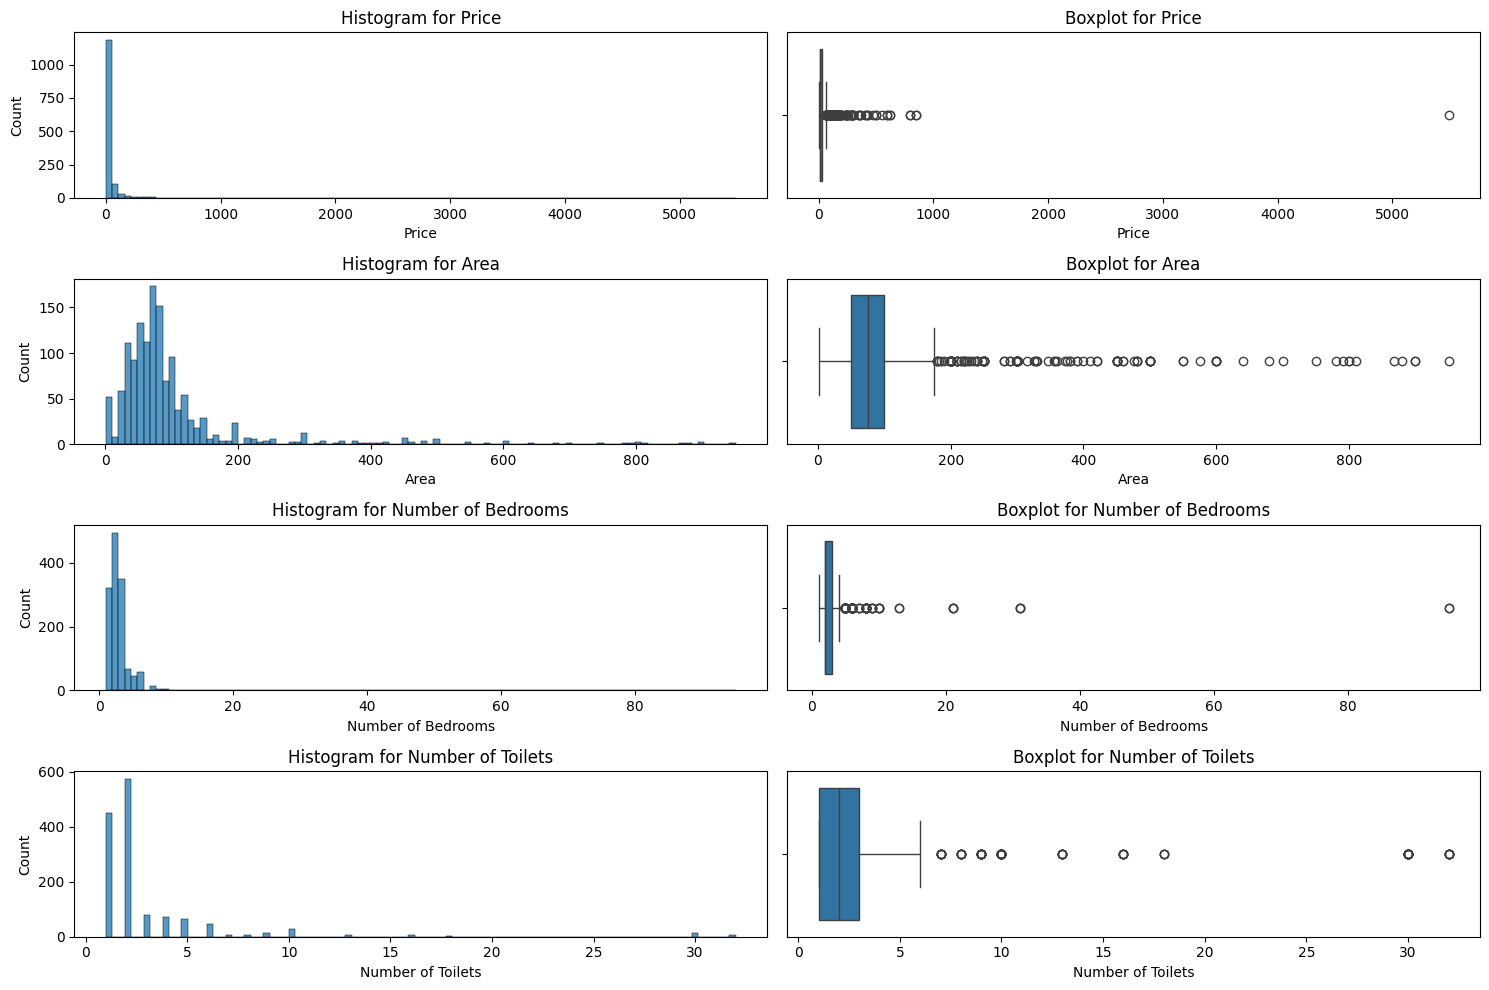

In [13]:
numerical_columns = ['Price', 'Area', 'Number of Bedrooms', 'Number of Toilets']


plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):

    plt.subplot(4, 2, 2*i-1)
    sns.histplot(training_data[column], bins=100)
    plt.title(f'Histogram for {column}')

    plt.subplot(4, 2, 2*i)
    sns.boxplot(data=training_data, x=column)
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis for Numerical Columns

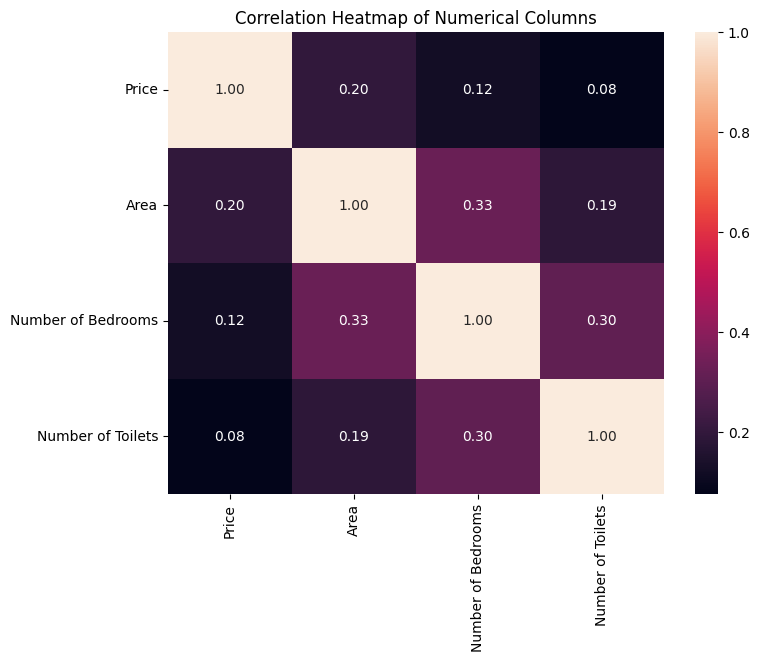

In [14]:
correlation_matrix = training_data[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

The correlations between these variables are relatively weak. Area and Number of Bedrooms show a moderate relationship, but Price does not strongly depend on any of the factors in the dataset.

### 3.6 Encode Categorical Variables

We will encode the categorical columns into numerical values to make them suitable for machine learning models.

In [15]:
categorical_columns = ['Category', 'City', 'Furniture', 'District']


In [30]:
training_data_encoded = pd.get_dummies(training_data, columns=categorical_columns, prefix=categorical_columns)

prediction_data_encoded = pd.get_dummies(prediction_data, columns=categorical_columns, prefix=categorical_columns)
prediction_data_encoded = prediction_data_encoded.reindex(columns=training_data_encoded.columns, fill_value=0)

In [17]:
training_data_encoded.head()

,Area,Price,Number of Bedrooms,Number of Toilets,Number of Rooms,"Category_Chung cư mini, căn hộ dịch vụ",Category_Căn hộ chung cư,"Category_Cửa hàng, ki ốt","Category_Kho, nhà xưởng, đất","Category_Nhà biệt thự, liền kề",...,District_Thuận an,District_Thạch thất,District_Thủ dầu một,District_Thủ đức,District_Tân bình,District_Tân phú,District_Tân uyên,District_Tây hồ,District_Đông anh,District_Đống đa
1,220.0,50.0,3.0,18.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,65.0,4.0,2.0,2.0,2.0,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,66.0,4.0,2.0,2.0,2.0,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,55.0,5.0,2.0,1.0,2.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,68.0,12.0,2.0,2.0,2.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 4. Modeling

### 4.1 Feature scaling  
Feature scaling is an important step when preparing data for machine learning models, especially for algorithms that are sensitive to the scale of the input features

In [20]:
scaler = StandardScaler()
numerical_columns = ['Area', 'Number of Bedrooms', 'Number of Toilets']
training_data_encoded.loc[:, numerical_columns] = scaler.fit_transform(training_data[numerical_columns])
prediction_data_encoded.loc[:, numerical_columns] = scaler.transform(prediction_data[numerical_columns])
prediction_data_encoded = prediction_data_encoded.reindex(columns=training_data.columns, fill_value=0)

### 4.2 Modeling

For house rent prediction, training multiple regression models is a great approach to identify the best-performing one. Thoose are:
- Linear Regression  
- Decision Tree  
- XGboost  
- Gradient Boost  
- Random Forest

In [21]:
X = training_data_encoded.drop('Price', axis=1)
y = training_data_encoded['Price']

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')
}

In [24]:
param_grids = {
    "Linear Regression": {},
    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
    }
}

model_results = []
best_models = {}
scores = {}

In [25]:
for name, model in models.items():
    param_grid = param_grids[name]

    if param_grid:
        if name == "XGBoost":
            xgb_random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
            xgb_random_search.fit(X_train, y_train)
            best_model = xgb_random_search.best_estimator_
            best_params = xgb_random_search.best_params_
        else:
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
    else:
        best_model = model.fit(X_train, y_train)
        best_params = {}

    y_pred = best_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    model_results.append({
        'Model': name,
        'Best Parameters': best_params,
        'MAE': mae,
        'MSE': mse,
        'R-squared': r2
    })

In [26]:
results_df = pd.DataFrame(model_results)
results_df

,Model,Best Parameters,MAE,MSE,R-squared
0,Linear Regression,{},7.634415e+11,4.083088e+25,-6.109394e+21
1,Decision Tree,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",1.898244e+01,2.312370e+03,6.540074e-01
2,Random Forest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",2.031488e+01,3.749744e+03,4.389378e-01
3,Gradient Boosting,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",1.851801e+01,2.155072e+03,6.775434e-01
4,XGBoost,"{'n_estimators': 200, 'min_child_weight': 5, '...",3.258958e+01,1.849314e+04,-1.767069e+00


**Conclusion:**
- Best Model: Gradient Boosting emerged as the best-performing model, exhibiting the lowest MAE and MSE values along with the highest R-squared score.
- Worst Model: Linear Regression and XGBoost performed poorly, indicating they are not suitable for this prediction task.

## 5. Predicting values

Use the best model to predict the price

In [27]:
best_model_name = results_df.loc[results_df['MAE'].idxmin(), 'Model']
best_model_params = results_df.loc[results_df['MAE'].idxmin(), 'Best Parameters']
best_model = models[best_model_name].set_params(**best_model_params)

In [28]:
best_model.fit(X, y)


GradientBoostingRegressor(learning_rate=0.2, max_depth=5)

In [33]:
prediction_data_encoded_new = prediction_data_encoded.drop(columns=['Price'])

predicted_prices = best_model.predict(prediction_data_encoded_new)

In [34]:
predicted_prices

array([ 245.82252728,  243.89279197,  255.62700528,  248.55758676,
        238.68882846,  255.28299416,  215.19121442,  161.46144313,
        210.58910704,   33.0550326 ,  245.4788773 ,  190.48398825,
        443.49114705,  253.7358967 ,  240.12033589,  165.45456952,
        477.96919739,  366.71039592,  129.25077757,  209.6313589 ,
         97.5139995 ,  183.17563529,  409.47950117,   23.15165307,
        197.79528386,  278.34499351,  196.58615961,  113.36948331,
         86.00831003,  240.04263503,  250.45742407,  182.17829413,
        194.72076842,  203.28115763,  197.19648013,  199.63216035,
        226.79810766,  264.17042641,  208.87121766, 2041.09389316,
        190.48398825,   92.25027199,  124.80787414,  225.21202233,
        272.20342218,  197.2595482 ,  165.93731934,  244.29808781,
        244.86854721,  329.40279782,  169.49434017,  378.41857743,
        225.21202233,  253.30154837,  578.26941756,  340.20948028,
        274.12044478,  274.12044478,  449.02014622,  277.11178

Fill the price in df

In [35]:
prediction_data_encoded['Price'] = predicted_prices

In [36]:
prediction_data_encoded.head()

,Area,Price,Number of Bedrooms,Number of Toilets,Number of Rooms,"Category_Chung cư mini, căn hộ dịch vụ",Category_Căn hộ chung cư,"Category_Cửa hàng, ki ốt","Category_Kho, nhà xưởng, đất","Category_Nhà biệt thự, liền kề",...,District_Thuận an,District_Thạch thất,District_Thủ dầu một,District_Thủ đức,District_Tân bình,District_Tân phú,District_Tân uyên,District_Tây hồ,District_Đông anh,District_Đống đa
0,80.0,245.822527,2.0,2.0,2.0,0,True,False,False,False,...,0,0,0,0,False,0,0,False,False,False
10,108.0,243.892792,3.0,1.0,1.0,0,False,False,False,False,...,0,0,0,0,False,0,0,False,False,False
18,14.5,255.627005,3.0,16.0,1.0,0,False,False,False,False,...,0,0,0,0,False,0,0,False,False,False
21,99.0,248.557587,2.0,2.0,2.0,0,True,False,False,False,...,0,0,0,0,False,0,0,False,False,False
32,80.0,238.688828,3.0,4.0,1.0,0,False,False,False,False,...,0,0,0,0,False,0,0,False,False,False


save the model and scaler

In [37]:
joblib.dump(best_model, 'model/house_rent_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']